In [4]:
### import required libraries and pkgs ###
import glob
import os
import librosa
import numpy as np
#from sklearn.model_selection import KFold
#from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
#import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [5]:
def Myextract_features(filePath, sampleRate=44100):
    factor = 0.4 #alpha
    
    signal,sr = librosa.load(filePath, sampleRate)
    signal = librosa.effects.time_stretch(signal,factor)
    centroid = librosa.feature.spectral_centroid(y=signal,sr=sr)
    mfcc = librosa.feature.mfcc(y=signal, sr=sr)
    #features = librosa.feature.melspectrogram(y=signal,sr=sr, n_mels=1)
    mel = librosa.feature.melspectrogram(y=signal, sr=sr)

    features = np.concatenate((mel,mfcc,centroid),axis=0)
    #features = np.concatenate((centroid,slope),axis=0)
    
    return features

In [6]:
#new features two features

def Myextract_features(filePath, sampleRate=44100):
    
    signal,sr = librosa.load(filePath, sampleRate)

    centroid = librosa.feature.spectral_centroid(y=signal,sr=sr)
    #mfcc = librosa.feature.mfcc(y=signal, sr=sr)
    #features = librosa.feature.melspectrogram(y=signal,sr=sr, n_mels=1)
    slope = librosa.feature.melspectrogram(y=signal, sr=sr)

    #features = np.concatenate((mel,mfcc),axis=0)
    features = np.concatenate((centroid,slope),axis=0)
    
    return features

In [7]:
#read all noraml files
parent_dir = '/Users/pooyan/Desktop/suction/'
sub_dir = 'normal/'
file_ext='*.ogg'
all_Normalfiles = glob.glob(os.path.join(parent_dir, sub_dir, file_ext))#[0:350]

all_noraml_features = [] #define an empty array
all_noraml_labels = []
for i in range(0,len(all_Normalfiles)):
    my_features = Myextract_features(all_Normalfiles[i])
    all_noraml_features.append(my_features)
    all_noraml_labels.append("normal")

#use reshape to conver outputs into arrays
dim_1 = len(all_Normalfiles)
dim_2 = my_features.shape[0] #number of features
dim_3 = my_features.shape[1]
all_noraml_features = np.asarray(all_noraml_features).reshape(dim_1, dim_2, dim_3)
all_noraml_labels = np.asarray(all_noraml_labels).reshape(dim_1)

#check the dimentions
print(all_noraml_features.shape)
print(all_noraml_labels.shape)

#read all anoamly files
parent_dir = '/Users/pooyan/Desktop/suction/'
sub_dir = 'anomaly/'
file_ext='*.ogg'
all_Anomalyfiles = glob.glob(os.path.join(parent_dir, sub_dir, file_ext))#[0:350]

all_anomaly_features = [] #define an empty array
all_anomaly_labels = []
for i in range(0,len(all_Anomalyfiles)):
    my_features = Myextract_features(all_Anomalyfiles[i])
    all_anomaly_features.append(my_features)
    all_anomaly_labels.append("anomaly")

#use reshape to conver outputs into arrays
dim_1 = len(all_Anomalyfiles)
dim_2 = my_features.shape[0] #number of features
dim_3 = my_features.shape[1]
all_anomaly_features = np.asarray(all_anomaly_features).reshape(dim_1, dim_2, dim_3)
all_anomaly_labels = np.asarray(all_anomaly_labels).reshape(dim_1)

#check the dimentions
print(all_anomaly_features.shape)
print(all_anomaly_labels.shape)

#Merge noraml and anomaly arrays
all_data = np.concatenate((all_noraml_features,all_anomaly_features),axis=0)
all_label = np.concatenate((all_noraml_labels,all_anomaly_labels),axis=0)

#check the dimentions
print(all_data.shape)

(9428, 129, 259)
(9428,)
(1282, 129, 259)
(1282,)
(10710, 129, 259)


In [8]:
#endocding labels two features
my_ec = LabelEncoder()
all_label = my_ec.fit_transform(all_label)

my_ec.transform(["normal"])
my_ec.inverse_transform(all_label)

#split data into train. validation, and test
X_train, X_test, y_train, y_test = train_test_split(all_data,all_label,test_size=0.2,shuffle=True)
X_train, X_validation, y_train, y_validation = train_test_split(X_train,y_train,test_size=0.2,shuffle=True)

#check the dimentions
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

#check the dimentions
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

(6854, 129, 259)
(2142, 129, 259)
(1714, 129, 259)
(6854, 129, 259)
(2142, 129, 259)
(1714, 129, 259)


In [7]:
#endocding labels
my_ec = LabelEncoder()
all_label = my_ec.fit_transform(all_label)

my_ec.transform(["normal"])
my_ec.inverse_transform(all_label)

#split data into train. validation, and test
X_train, X_test, y_train, y_test = train_test_split(all_data,all_label,test_size=0.2,shuffle=True)
X_train, X_validation, y_train, y_validation = train_test_split(X_train,y_train,test_size=0.2,shuffle=True)

#check the dimentions
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

#check the dimentions
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

(6854, 149, 646)
(2142, 149, 646)
(1714, 149, 646)
(6854, 149, 646)
(2142, 149, 646)
(1714, 149, 646)


In [8]:
# two sided model
#from keras.layers.core import Input, Model
#with dropout
from keras.layers import *
from keras.models import *
from keras.utils import *
from keras.initializers import *
import tensorflow as tf


inputs = Input((149,646))

side1 = Bidirectional(LSTM(100, return_sequences=True))(inputs) #200 total units
side2 = Conv1D(200, kernel_size=3, activation = 'relu', padding = 'same')(inputs) #same activation 
                                                                   #same length

merged = Add()([side1, side2]) 
     #or Concatenate()([side1, side2]) if different number of units/channels/features

outputs = Conv1D(200, kernel_size=3)(merged)
outputs = GlobalMaxPooling1D()(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(100)(outputs)
outputs = Dropout(0.2)(outputs)
outputs = Dense(2, activation='softmax')(outputs)

model5 = Model(inputs, outputs)
model5.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 149, 646)]   0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 149, 200)     597600      ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 149, 200)     387800      ['input_1[0][0]']                
                                                                                                  
 add (Add)                      (None, 149, 200)     0           ['bidirectional[0][0]',          
                                                                  'conv1d[0][0]']             

In [9]:
model5.compile(optimizer=keras.optimizers.Adam(1e-4),loss=tf.losses.SparseCategoricalCrossentropy(), metrics=["accuracy", "MeanSquaredError"])
history=model5.fit(X_train, y_train, validation_data=(X_validation, y_validation),epochs = 30, batch_size = 128, verbose = 1)

Epoch 1/30
54/54 [==============================] - 25s 419ms/step - loss: 0.3076 - accuracy: 0.9059 - mean_squared_error: 0.3958 - val_loss: 0.2535 - val_accuracy: 0.9708 - val_mean_squared_error: 0.4995
Epoch 2/30
54/54 [==============================] - 21s 389ms/step - loss: 0.0906 - accuracy: 0.9828 - mean_squared_error: 0.4550 - val_loss: 0.1471 - val_accuracy: 0.9714 - val_mean_squared_error: 0.4988
Epoch 3/30
54/54 [==============================] - 21s 389ms/step - loss: 0.0553 - accuracy: 0.9867 - mean_squared_error: 0.4735 - val_loss: 0.0315 - val_accuracy: 0.9883 - val_mean_squared_error: 0.4936
Epoch 4/30
54/54 [==============================] - 23s 431ms/step - loss: 0.0471 - accuracy: 0.9895 - mean_squared_error: 0.4796 - val_loss: 0.0299 - val_accuracy: 0.9889 - val_mean_squared_error: 0.4942
Epoch 5/30
54/54 [==============================] - 25s 461ms/step - loss: 0.0456 - accuracy: 0.9896 - mean_squared_error: 0.4832 - val_loss: 0.0280 - val_accuracy: 0.9907 - val_me

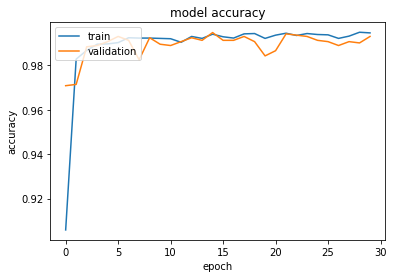

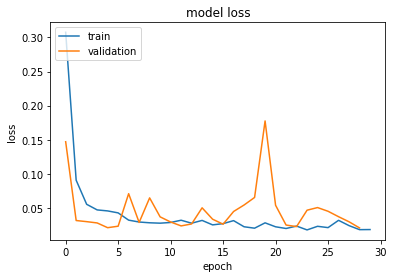

In [10]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'][1:43])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [12]:
#test
pred = model5.predict(X_test)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]

#test

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

Accuracy: 0.992997
Precision: 0.993151
Recall: 0.998940
F1 score: 0.996037
Cohens kappa: 0.965979
ROC AUC: 0.973980
[[ 242   13]
 [   2 1885]]


In [13]:
#train
from sklearn.metrics import confusion_matrix

pred = model5.predict(X_train)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]   #thereshold=50 y[0]>0.50


from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_train, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_train, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_train, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_train, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_train, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_train, y_pred)
print(matrix)

Accuracy: 0.993434
Precision: 0.995033
Recall: 0.997510
F1 score: 0.996270
Cohens kappa: 0.968882
ROC AUC: 0.980661
[[ 799   30]
 [  15 6010]]


In [16]:
#train
from sklearn.metrics import confusion_matrix

pred = model5.predict(X_train)
y_pred = [0 if y[0]>0.40 else 1 for y in pred]   #thereshold=50 y[0]>0.50


from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_train, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_train, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_train, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_train, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_train, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_train, y_pred)
print(matrix)

Accuracy: 0.993872
Precision: 0.995692
Recall: 0.997344
F1 score: 0.996517
Cohens kappa: 0.971032
ROC AUC: 0.982991
[[ 803   26]
 [  16 6009]]


In [21]:
#train
from sklearn.metrics import confusion_matrix

pred = model5.predict(X_train)
y_pred = [0 if y[0]>0.30 else 1 for y in pred]   #thereshold=50 y[0]>0.50


from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_train, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_train, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_train, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_train, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_train, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_train, y_pred)
print(matrix)

Accuracy: 0.994310
Precision: 0.996352
Recall: 0.997178
F1 score: 0.996765
Cohens kappa: 0.973171
ROC AUC: 0.985320
[[ 807   22]
 [  17 6008]]


In [14]:
#two features
def Myextract_features(filePath, sampleRate=44100):
    
    signal,sr = librosa.load(filePath, sampleRate)

    #centroid = librosa.feature.spectral_centroid(y=signal,sr=sr)
    mfcc = librosa.feature.mfcc(y=signal, sr=sr)
    #features = librosa.feature.melspectrogram(y=signal,sr=sr, n_mels=1)
    mel = librosa.feature.melspectrogram(y=signal, sr=sr)

    features = np.concatenate((mel,mfcc),axis=0)

    return features

In [15]:
#read all noraml files
parent_dir = '/Users/pooyan/Desktop/suction/'
sub_dir = 'normal/'
file_ext='*.ogg'
all_Normalfiles = glob.glob(os.path.join(parent_dir, sub_dir, file_ext))#[0:350]

all_noraml_features = [] #define an empty array
all_noraml_labels = []
for i in range(0,len(all_Normalfiles)):
    my_features = Myextract_features(all_Normalfiles[i])
    all_noraml_features.append(my_features)
    all_noraml_labels.append("normal")

#use reshape to conver outputs into arrays
dim_1 = len(all_Normalfiles)
dim_2 = my_features.shape[0] #number of features
dim_3 = my_features.shape[1]
all_noraml_features = np.asarray(all_noraml_features).reshape(dim_1, dim_2, dim_3)
all_noraml_labels = np.asarray(all_noraml_labels).reshape(dim_1)

#check the dimentions
print(all_noraml_features.shape)
print(all_noraml_labels.shape)

#read all anoamly files
parent_dir = '/Users/pooyan/Desktop/suction/'
sub_dir = 'anomaly/'
file_ext='*.ogg'
all_Anomalyfiles = glob.glob(os.path.join(parent_dir, sub_dir, file_ext))#[0:350]

all_anomaly_features = [] #define an empty array
all_anomaly_labels = []
for i in range(0,len(all_Anomalyfiles)):
    my_features = Myextract_features(all_Anomalyfiles[i])
    all_anomaly_features.append(my_features)
    all_anomaly_labels.append("anomaly")

#use reshape to conver outputs into arrays
dim_1 = len(all_Anomalyfiles)
dim_2 = my_features.shape[0] #number of features
dim_3 = my_features.shape[1]
all_anomaly_features = np.asarray(all_anomaly_features).reshape(dim_1, dim_2, dim_3)
all_anomaly_labels = np.asarray(all_anomaly_labels).reshape(dim_1)

#check the dimentions
print(all_anomaly_features.shape)
print(all_anomaly_labels.shape)

#Merge noraml and anomaly arrays
all_data = np.concatenate((all_noraml_features,all_anomaly_features),axis=0)
all_label = np.concatenate((all_noraml_labels,all_anomaly_labels),axis=0)

#check the dimentions
print(all_data.shape)

(9428, 148, 259)
(9428,)
(1282, 148, 259)
(1282,)
(10710, 148, 259)


In [22]:
#endocding labels
my_ec = LabelEncoder()
all_label = my_ec.fit_transform(all_label)

my_ec.transform(["normal"])
my_ec.inverse_transform(all_label)

#split data into train. validation, and test
X_train, X_test, y_train, y_test = train_test_split(all_data,all_label,test_size=0.2,shuffle=True)
X_train, X_validation, y_train, y_validation = train_test_split(X_train,y_train,test_size=0.2,shuffle=True)

#check the dimentions
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

#check the dimentions
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

(6854, 148, 259)
(2142, 148, 259)
(1714, 148, 259)
(6854, 148, 259)
(2142, 148, 259)
(1714, 148, 259)


In [23]:
from keras import layers as keras_layers
import numpy as np    
from keras.layers.convolutional import Conv1D    
from keras.layers.convolutional import MaxPooling1D 

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(148,259)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 146, 64)           49792     
                                                                 
 conv1d_3 (Conv1D)           (None, 144, 64)           12352     
                                                                 
 dropout_1 (Dropout)         (None, 144, 64)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 72, 64)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense_2 (Dense)             (None, 100)               460900    
                                                        

In [24]:
model.compile(optimizer=keras.optimizers.Adam(1e-4),loss=tf.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
history=model.fit(X_train, y_train, validation_data=(X_validation, y_validation),epochs = 30, batch_size = 128, verbose = 1)


Epoch 1/30
54/54 [==============================] - 4s 49ms/step - loss: 20.6661 - accuracy: 0.9380 - val_loss: 6.3932 - val_accuracy: 0.9796
Epoch 2/30
54/54 [==============================] - 3s 48ms/step - loss: 5.2516 - accuracy: 0.9685 - val_loss: 2.2515 - val_accuracy: 0.9877
Epoch 3/30
54/54 [==============================] - 3s 50ms/step - loss: 3.2588 - accuracy: 0.9737 - val_loss: 1.0199 - val_accuracy: 0.9883
Epoch 4/30
54/54 [==============================] - 3s 48ms/step - loss: 2.0303 - accuracy: 0.9823 - val_loss: 0.9727 - val_accuracy: 0.9901
Epoch 5/30
54/54 [==============================] - 3s 48ms/step - loss: 1.2973 - accuracy: 0.9844 - val_loss: 0.7494 - val_accuracy: 0.9901
Epoch 6/30
54/54 [==============================] - 3s 49ms/step - loss: 1.3513 - accuracy: 0.9844 - val_loss: 0.6330 - val_accuracy: 0.9901
Epoch 7/30
54/54 [==============================] - 3s 49ms/step - loss: 1.1396 - accuracy: 0.9860 - val_loss: 0.3159 - val_accuracy: 0.9936
Epoch 8/30
5

In [25]:
#test
pred = model.predict(X_test)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]

#test

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

Accuracy: 0.990196
Precision: 0.993627
Recall: 0.995213
F1 score: 0.994419
Cohens kappa: 0.954112
ROC AUC: 0.974706
[[ 250   12]
 [   9 1871]]


In [26]:
from sklearn.metrics import confusion_matrix

pred = model.predict(X_train)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]   #thereshold=50 y[0]>0.50

cm=confusion_matrix(y_train,y_pred)
print("train set")
print("0:%s - 1:%s"%(my_ec.inverse_transform([0])[0],my_ec.inverse_transform([1])[0]))
print(cm)

accuracy = (cm[0,0]+cm[1,1])/cm.sum()
precision= (cm[0,0])/(cm[0,0]+cm[1,0])
recall = (cm[0,0])/(cm[0,0]+cm[0,1])
f1=2*precision*recall/(precision+recall)

print("accuracy=%.2f f1score=%.2f"%(accuracy, f1))
print("precision=%.2f recall=%.2f"%(precision, recall))

train set
0:anomaly - 1:normal
[[ 788   19]
 [  12 6035]]
accuracy=1.00 f1score=0.98
precision=0.98 recall=0.98


In [32]:
#train
from sklearn.metrics import confusion_matrix

pred = model.predict(X_train)
y_pred = [0 if y[0]>0.09 else 1 for y in pred]   #thereshold=50 y[0]>0.50


from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_train, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_train, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_train, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_train, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_train, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_train, y_pred)
print(matrix)

Accuracy: 0.995477
Precision: 0.996862
Recall: 0.998016
F1 score: 0.997438
Cohens kappa: 0.978148
ROC AUC: 0.987236
[[ 788   19]
 [  12 6035]]


In [37]:
model = tf.keras.Sequential()
model.add(LSTM(50, input_shape=(148,259)))
#model.add(tf.keras.layers.LSTM(64))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(2,activation = 'softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50)                62000     
                                                                 
 dense_10 (Dense)            (None, 64)                3264      
                                                                 
 dense_11 (Dense)            (None, 2)                 130       
                                                                 
Total params: 65,394
Trainable params: 65,394
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.compile(optimizer=keras.optimizers.Adam(1e-4),loss=tf.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
history=model.fit(X_train, y_train, validation_data=(X_validation, y_validation),epochs = 30, batch_size = 128, verbose = 1)


Epoch 1/30
54/54 [==============================] - 6s 88ms/step - loss: 0.4028 - accuracy: 0.8764 - val_loss: 0.3838 - val_accuracy: 0.8740
Epoch 2/30
54/54 [==============================] - 4s 82ms/step - loss: 0.3593 - accuracy: 0.8823 - val_loss: 0.3647 - val_accuracy: 0.8751
Epoch 3/30
54/54 [==============================] - 5s 84ms/step - loss: 0.3407 - accuracy: 0.8823 - val_loss: 0.3493 - val_accuracy: 0.8757
Epoch 4/30
54/54 [==============================] - 5s 84ms/step - loss: 0.3256 - accuracy: 0.8823 - val_loss: 0.3356 - val_accuracy: 0.8757
Epoch 5/30
54/54 [==============================] - 4s 83ms/step - loss: 0.3110 - accuracy: 0.8823 - val_loss: 0.3258 - val_accuracy: 0.8757
Epoch 6/30
54/54 [==============================] - 5s 86ms/step - loss: 0.2982 - accuracy: 0.8821 - val_loss: 0.3098 - val_accuracy: 0.8769
Epoch 7/30
54/54 [==============================] - 5s 84ms/step - loss: 0.2836 - accuracy: 0.8823 - val_loss: 0.3020 - val_accuracy: 0.8763
Epoch 8/30
54

In [39]:
#train
from sklearn.metrics import confusion_matrix

pred = model.predict(X_train)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]   #thereshold=50 y[0]>0.50


from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_train, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_train, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_train, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_train, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_train, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_train, y_pred)
print(matrix)

Accuracy: 0.987161
Precision: 0.992073
Recall: 0.993385
F1 score: 0.992728
Cohens kappa: 0.937934
ROC AUC: 0.966953
[[ 759   48]
 [  40 6007]]


In [40]:
#test
pred = model.predict(X_test)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]

#test

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

Accuracy: 0.944444
Precision: 0.954569
Recall: 0.983511
F1 score: 0.968824
Cohens kappa: 0.714526
ROC AUC: 0.823816
[[ 174   88]
 [  31 1849]]


In [44]:
# define LSTM
model = Sequential()
model.add(Bidirectional(LSTM(20, return_sequences=True), input_shape=(148,259)))
model.add(TimeDistributed(Dense(1, activation='softmax')))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 148, 40)          44800     
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 148, 1)           41        
 tributed)                                                       
                                                                 
Total params: 44,841
Trainable params: 44,841
Non-trainable params: 0
_________________________________________________________________


In [45]:
from keras import layers as keras_layers
import numpy as np    
from keras.layers.convolutional import Conv1D    
from keras.layers.convolutional import MaxPooling1D 
from keras.layers import Flatten, RepeatVector, Bidirectional

model = Sequential()
model.add(Conv1D(filters=256, kernel_size=2, activation='relu', input_shape=(148,259)))
#model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(RepeatVector(30))
#model.add(LSTM(units=25, return_sequences=True, activation='relu'))
#model.add(Dropout(0.2))
#model.add(LSTM(units=25, return_sequences=True, activation='relu'))
#model.add(Dropout(0.2))
#model.add(LSTM(units=25, return_sequences=True, activation='relu'))
model.add(LSTM(units=50, return_sequences=True, activation='relu'))
model.add(Bidirectional(LSTM(128, activation='relu')))
model.add(Dense(50, activation='relu'))
model.add(Dense(2))
#model.compile(loss='mae', optimizer='adam', metrics=['mse'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 147, 256)          132864    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 73, 256)          0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 18688)             0         
                                                                 
 repeat_vector (RepeatVector  (None, 30, 18688)        0         
 )                                                               
                                                                 
 lstm_8 (LSTM)               (None, 30, 50)            3747800   
                                                                 
 bidirectional_3 (Bidirectio  (None, 256)             

In [46]:
model.compile(optimizer=keras.optimizers.Adam(1e-4),loss=tf.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
history=model.fit(X_train, y_train, validation_data=(X_validation, y_validation),epochs = 30, batch_size = 128, verbose = 1)


Epoch 1/30
54/54 [==============================] - 42s 736ms/step - loss: 3.2544 - accuracy: 0.5865 - val_loss: 2.9190 - val_accuracy: 0.6517
Epoch 2/30
54/54 [==============================] - 40s 736ms/step - loss: 2.3133 - accuracy: 0.7539 - val_loss: 2.4748 - val_accuracy: 0.7637
Epoch 3/30
54/54 [==============================] - 40s 749ms/step - loss: 2.2428 - accuracy: 0.7741 - val_loss: 2.2633 - val_accuracy: 0.7270
Epoch 4/30
54/54 [==============================] - 40s 743ms/step - loss: 2.5047 - accuracy: 0.7149 - val_loss: 2.7297 - val_accuracy: 0.7188
Epoch 5/30
54/54 [==============================] - 41s 753ms/step - loss: 2.9364 - accuracy: 0.6830 - val_loss: 3.1352 - val_accuracy: 0.6534
Epoch 6/30
54/54 [==============================] - 41s 768ms/step - loss: 3.0769 - accuracy: 0.6703 - val_loss: 3.1811 - val_accuracy: 0.6593
Epoch 7/30
54/54 [==============================] - 42s 774ms/step - loss: 2.9520 - accuracy: 0.6824 - val_loss: 2.5445 - val_accuracy: 0.7200

KeyboardInterrupt: 

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(10, return_sequences=True),
                             input_shape=(148,259)))
model.add(Bidirectional(LSTM(10)))
model.add(Dense(2, activation='softmax'))
#model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
model.summary()

In [ ]:
model = Sequential()
model.add(Conv1D(64, 2, activation="relu", input_shape=(129,259)))
model.add(Dense(16, activation="relu"))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(2, activation = 'softmax'))
model.summary()

In [ ]:
model = Sequential()
model.add(LSTM(200, return_sequences=True, input_shape=(129,259)))
model.add(Conv1D(200, kernel_size=3, activation = 'relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(Dense(100))
model.add(Dense(2, activation='sigmoid'))
model.summary()

In [47]:
#new features

def Myextract_features(filePath, sampleRate=44100):
    
    signal,sr = librosa.load(filePath, sampleRate)

    centroid = librosa.feature.spectral_centroid(y=signal,sr=sr)
    #mfcc = librosa.feature.mfcc(y=signal, sr=sr)
    #features = librosa.feature.melspectrogram(y=signal,sr=sr, n_mels=1)
    slope = librosa.feature.melspectrogram(y=signal, sr=sr)

    #features = np.concatenate((mel,mfcc),axis=0)
    features = np.concatenate((centroid,slope),axis=0)
    
    return features

In [48]:
#read all noraml files
parent_dir = '/Users/pooyan/Desktop/suction/'
sub_dir = 'normal/'
file_ext='*.ogg'
all_Normalfiles = glob.glob(os.path.join(parent_dir, sub_dir, file_ext))#[0:350]

all_noraml_features = [] #define an empty array
all_noraml_labels = []
for i in range(0,len(all_Normalfiles)):
    my_features = Myextract_features(all_Normalfiles[i])
    all_noraml_features.append(my_features)
    all_noraml_labels.append("normal")

#use reshape to conver outputs into arrays
dim_1 = len(all_Normalfiles)
dim_2 = my_features.shape[0] #number of features
dim_3 = my_features.shape[1]
all_noraml_features = np.asarray(all_noraml_features).reshape(dim_1, dim_2, dim_3)
all_noraml_labels = np.asarray(all_noraml_labels).reshape(dim_1)

#check the dimentions
print(all_noraml_features.shape)
print(all_noraml_labels.shape)

#read all anoamly files
parent_dir = '/Users/pooyan/Desktop/suction/'
sub_dir = 'anomaly/'
file_ext='*.ogg'
all_Anomalyfiles = glob.glob(os.path.join(parent_dir, sub_dir, file_ext))#[0:350]

all_anomaly_features = [] #define an empty array
all_anomaly_labels = []
for i in range(0,len(all_Anomalyfiles)):
    my_features = Myextract_features(all_Anomalyfiles[i])
    all_anomaly_features.append(my_features)
    all_anomaly_labels.append("anomaly")

#use reshape to conver outputs into arrays
dim_1 = len(all_Anomalyfiles)
dim_2 = my_features.shape[0] #number of features
dim_3 = my_features.shape[1]
all_anomaly_features = np.asarray(all_anomaly_features).reshape(dim_1, dim_2, dim_3)
all_anomaly_labels = np.asarray(all_anomaly_labels).reshape(dim_1)

#check the dimentions
print(all_anomaly_features.shape)
print(all_anomaly_labels.shape)

#Merge noraml and anomaly arrays
all_data = np.concatenate((all_noraml_features,all_anomaly_features),axis=0)
all_label = np.concatenate((all_noraml_labels,all_anomaly_labels),axis=0)

#check the dimentions
print(all_data.shape)

(9428, 129, 259)
(9428,)
(1282, 129, 259)
(1282,)
(10710, 129, 259)


In [49]:
#endocding labels
my_ec = LabelEncoder()
all_label = my_ec.fit_transform(all_label)

my_ec.transform(["normal"])
my_ec.inverse_transform(all_label)

#split data into train. validation, and test
X_train, X_test, y_train, y_test = train_test_split(all_data,all_label,test_size=0.2,shuffle=True)
X_train, X_validation, y_train, y_validation = train_test_split(X_train,y_train,test_size=0.2,shuffle=True)

#check the dimentions
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

#check the dimentions
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

(6854, 129, 259)
(2142, 129, 259)
(1714, 129, 259)
(6854, 129, 259)
(2142, 129, 259)
(1714, 129, 259)


In [53]:
model2 = Sequential()
model2.add(LSTM(200, return_sequences=True, input_shape=(129,259)))
model2.add(Conv1D(200, kernel_size=3, activation = 'relu'))
model2.add(tf.keras.layers.GlobalMaxPooling1D())
model2.add(Dense(100))
model2.add(Dense(2, activation='sigmoid'))
model2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 129, 200)          368000    
                                                                 
 conv1d_6 (Conv1D)           (None, 127, 200)          120200    
                                                                 
 global_max_pooling1d_2 (Glo  (None, 200)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_18 (Dense)            (None, 100)               20100     
                                                                 
 dense_19 (Dense)            (None, 2)                 202       
                                                                 
Total params: 508,502
Trainable params: 508,502
Non-trainable params: 0
_______________________________________________

In [55]:
model2.compile(optimizer=keras.optimizers.Adam(1e-4),loss=tf.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
history=model2.fit(X_train, y_train, validation_data=(X_validation, y_validation),epochs = 20, batch_size = 128, verbose = 1)


Epoch 1/20
54/54 [==============================] - 14s 244ms/step - loss: 0.0303 - accuracy: 0.9920 - val_loss: 0.0266 - val_accuracy: 0.9924
Epoch 2/20
54/54 [==============================] - 13s 239ms/step - loss: 0.0216 - accuracy: 0.9931 - val_loss: 0.0246 - val_accuracy: 0.9912
Epoch 3/20
54/54 [==============================] - 13s 245ms/step - loss: 0.0183 - accuracy: 0.9937 - val_loss: 0.0244 - val_accuracy: 0.9918
Epoch 4/20
54/54 [==============================] - 14s 266ms/step - loss: 0.0160 - accuracy: 0.9937 - val_loss: 0.0286 - val_accuracy: 0.9901
Epoch 5/20
54/54 [==============================] - 16s 291ms/step - loss: 0.0145 - accuracy: 0.9937 - val_loss: 0.0264 - val_accuracy: 0.9912
Epoch 6/20
54/54 [==============================] - 16s 297ms/step - loss: 0.0130 - accuracy: 0.9940 - val_loss: 0.0313 - val_accuracy: 0.9901
Epoch 7/20
54/54 [==============================] - 15s 282ms/step - loss: 0.0130 - accuracy: 0.9939 - val_loss: 0.0273 - val_accuracy: 0.9901

In [56]:
#train
from sklearn.metrics import confusion_matrix

pred = model2.predict(X_train)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]   #thereshold=50 y[0]>0.50


from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_train, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_train, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_train, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_train, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_train, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_train, y_pred)
print(matrix)

Accuracy: 0.996061
Precision: 0.999500
Recall: 0.996017
F1 score: 0.997755
Cohens kappa: 0.981675
ROC AUC: 0.996199
[[ 826    3]
 [  24 6001]]


In [58]:
#test
pred = model2.predict(X_test)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]

#test

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

Accuracy: 0.991130
Precision: 0.996814
Recall: 0.993122
F1 score: 0.994964
Cohens kappa: 0.957783
ROC AUC: 0.984656
[[ 246    6]
 [  13 1877]]


In [59]:
model = Sequential()
model.add(LSTM(200, return_sequences=True, input_shape=(129,259)))
model.add(Conv1D(200, kernel_size=3, activation = 'relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(Dense(100))
model.add(Dense(2, activation='sigmoid'))
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 129, 200)          368000    
                                                                 
 conv1d_7 (Conv1D)           (None, 127, 200)          120200    
                                                                 
 global_max_pooling1d_3 (Glo  (None, 200)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_20 (Dense)            (None, 100)               20100     
                                                                 
 dense_21 (Dense)            (None, 2)                 202       
                                                                 
Total params: 508,502
Trainable params: 508,502
Non-trainable params: 0
_______________________________________________

In [60]:
model.compile(optimizer=keras.optimizers.Adam(1e-4),loss=tf.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
history=model.fit(X_train, y_train, validation_data=(X_validation, y_validation),epochs = 20, batch_size = 128, verbose = 1)


Epoch 1/20
54/54 [==============================] - 14s 234ms/step - loss: 0.1278 - accuracy: 0.9510 - val_loss: 0.0576 - val_accuracy: 0.9790
Epoch 2/20
54/54 [==============================] - 12s 232ms/step - loss: 0.0389 - accuracy: 0.9889 - val_loss: 0.0315 - val_accuracy: 0.9901
Epoch 3/20
54/54 [==============================] - 12s 229ms/step - loss: 0.0263 - accuracy: 0.9926 - val_loss: 0.0239 - val_accuracy: 0.9930
Epoch 4/20
54/54 [==============================] - 13s 239ms/step - loss: 0.0219 - accuracy: 0.9933 - val_loss: 0.0257 - val_accuracy: 0.9907
Epoch 5/20
54/54 [==============================] - 13s 244ms/step - loss: 0.0184 - accuracy: 0.9934 - val_loss: 0.0224 - val_accuracy: 0.9918
Epoch 6/20
54/54 [==============================] - 14s 255ms/step - loss: 0.0157 - accuracy: 0.9934 - val_loss: 0.0224 - val_accuracy: 0.9924
Epoch 7/20
54/54 [==============================] - 16s 289ms/step - loss: 0.0140 - accuracy: 0.9937 - val_loss: 0.0224 - val_accuracy: 0.9912

In [61]:
#train
from sklearn.metrics import confusion_matrix

pred = model.predict(X_train)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]   #thereshold=50 y[0]>0.50


from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_train, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_train, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_train, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_train, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_train, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_train, y_pred)
print(matrix)

Accuracy: 0.995623
Precision: 0.997510
Recall: 0.997510
F1 score: 0.997510
Cohens kappa: 0.979416
ROC AUC: 0.989708
[[ 814   15]
 [  15 6010]]


In [62]:
#test
pred = model.predict(X_test)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]

#test

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

Accuracy: 0.991597
Precision: 0.996815
Recall: 0.993651
F1 score: 0.995231
Cohens kappa: 0.959937
ROC AUC: 0.984921
[[ 246    6]
 [  12 1878]]


In [63]:
model = Sequential()
model.add(Conv1D(200, kernel_size=3, activation = 'relu', input_shape=(129,259)))
model.add(LSTM(200))
model.add(Dense(100))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 127, 200)          155600    
                                                                 
 lstm_13 (LSTM)              (None, 200)               320800    
                                                                 
 dense_22 (Dense)            (None, 100)               20100     
                                                                 
 dense_23 (Dense)            (None, 2)                 202       
                                                                 
Total params: 496,702
Trainable params: 496,702
Non-trainable params: 0
_________________________________________________________________


In [64]:
model.compile(optimizer=keras.optimizers.Adam(1e-4),loss=tf.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
history=model.fit(X_train, y_train, validation_data=(X_validation, y_validation),epochs = 20, batch_size = 128, verbose = 1)


Epoch 1/20
54/54 [==============================] - 17s 253ms/step - loss: 0.2491 - accuracy: 0.8790 - val_loss: 0.1630 - val_accuracy: 0.8827
Epoch 2/20
54/54 [==============================] - 13s 241ms/step - loss: 0.1487 - accuracy: 0.9600 - val_loss: 0.1031 - val_accuracy: 0.9685
Epoch 3/20
54/54 [==============================] - 13s 239ms/step - loss: 0.0971 - accuracy: 0.9867 - val_loss: 0.0574 - val_accuracy: 0.9936
Epoch 4/20
54/54 [==============================] - 14s 268ms/step - loss: 0.0722 - accuracy: 0.9904 - val_loss: 0.0382 - val_accuracy: 0.9936
Epoch 5/20
54/54 [==============================] - 17s 309ms/step - loss: 0.0450 - accuracy: 0.9904 - val_loss: 0.0230 - val_accuracy: 0.9930
Epoch 6/20
54/54 [==============================] - 17s 309ms/step - loss: 0.0291 - accuracy: 0.9927 - val_loss: 0.0259 - val_accuracy: 0.9930
Epoch 7/20
54/54 [==============================] - 16s 300ms/step - loss: 0.0271 - accuracy: 0.9923 - val_loss: 0.0209 - val_accuracy: 0.9936

In [65]:
#train
from sklearn.metrics import confusion_matrix

pred = model.predict(X_train)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]   #thereshold=50 y[0]>0.50


from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_train, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_train, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_train, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_train, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_train, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_train, y_pred)
print(matrix)

Accuracy: 0.995477
Precision: 0.999833
Recall: 0.995021
F1 score: 0.997421
Cohens kappa: 0.979046
ROC AUC: 0.996907
[[ 828    1]
 [  30 5995]]


In [66]:
#test
pred = model.predict(X_test)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]

#test

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

Accuracy: 0.993464
Precision: 0.998936
Recall: 0.993651
F1 score: 0.996286
Cohens kappa: 0.969051
ROC AUC: 0.992857
[[ 250    2]
 [  12 1878]]


In [ ]:
model = Sequential()
model.add(Conv1D(40, kernel_size=3, activation = 'relu', input_shape=(129,259)))
model.add(LSTM(30, return_sequences=True))
model.add(Conv1D(20, kernel_size=3, activation = 'relu'))
model.add(Dropout(rate=0.2))
model.add(LSTM(100))
model.add(Dropout(rate=0.2))
model.add(Dense(100))
model.add(Dropout(rate=0.2))
model.add(Dense(2, activation='softmax'))
model.summary()

In [67]:
##replicate

In [68]:


#new features

def Myextract_features(filePath, sampleRate=44100):
    
    signal,sr = librosa.load(filePath, sampleRate)

    centroid = librosa.feature.spectral_centroid(y=signal,sr=sr)
    #mfcc = librosa.feature.mfcc(y=signal, sr=sr)
    #features = librosa.feature.melspectrogram(y=signal,sr=sr, n_mels=1)
    slope = librosa.feature.melspectrogram(y=signal, sr=sr)

    #features = np.concatenate((mel,mfcc),axis=0)
    features = np.concatenate((centroid,slope),axis=0)
    
    return features

In [69]:
#read all noraml files
parent_dir = '/Users/pooyan/Desktop/suction/'
sub_dir = 'normal/'
file_ext='*.ogg'
all_Normalfiles = glob.glob(os.path.join(parent_dir, sub_dir, file_ext))#[0:350]

all_noraml_features = [] #define an empty array
all_noraml_labels = []
for i in range(0,len(all_Normalfiles)):
    my_features = Myextract_features(all_Normalfiles[i])
    all_noraml_features.append(my_features)
    all_noraml_labels.append("normal")

#use reshape to conver outputs into arrays
dim_1 = len(all_Normalfiles)
dim_2 = my_features.shape[0] #number of features
dim_3 = my_features.shape[1]
all_noraml_features = np.asarray(all_noraml_features).reshape(dim_1, dim_2, dim_3)
all_noraml_labels = np.asarray(all_noraml_labels).reshape(dim_1)

#check the dimentions
print(all_noraml_features.shape)
print(all_noraml_labels.shape)

#read all anoamly files
parent_dir = '/Users/pooyan/Desktop/suction/'
sub_dir = 'anomaly/'
file_ext='*.ogg'
all_Anomalyfiles = glob.glob(os.path.join(parent_dir, sub_dir, file_ext))#[0:350]

all_anomaly_features = [] #define an empty array
all_anomaly_labels = []
for i in range(0,len(all_Anomalyfiles)):
    my_features = Myextract_features(all_Anomalyfiles[i])
    all_anomaly_features.append(my_features)
    all_anomaly_labels.append("anomaly")

#use reshape to conver outputs into arrays
dim_1 = len(all_Anomalyfiles)
dim_2 = my_features.shape[0] #number of features
dim_3 = my_features.shape[1]
all_anomaly_features = np.asarray(all_anomaly_features).reshape(dim_1, dim_2, dim_3)
all_anomaly_labels = np.asarray(all_anomaly_labels).reshape(dim_1)

#check the dimentions
print(all_anomaly_features.shape)
print(all_anomaly_labels.shape)

#Merge noraml and anomaly arrays
all_data = np.concatenate((all_noraml_features,all_anomaly_features),axis=0)
all_label = np.concatenate((all_noraml_labels,all_anomaly_labels),axis=0)

#check the dimentions
print(all_data.shape)

(9428, 129, 259)
(9428,)
(1282, 129, 259)
(1282,)
(10710, 129, 259)


In [70]:
#endocding labels
my_ec = LabelEncoder()
all_label = my_ec.fit_transform(all_label)

my_ec.transform(["normal"])
my_ec.inverse_transform(all_label)

#split data into train. validation, and test
X_train, X_test, y_train, y_test = train_test_split(all_data,all_label,test_size=0.2,shuffle=True)
X_train, X_validation, y_train, y_validation = train_test_split(X_train,y_train,test_size=0.2,shuffle=True)

#check the dimentions
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

#check the dimentions
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

(6854, 129, 259)
(2142, 129, 259)
(1714, 129, 259)
(6854, 129, 259)
(2142, 129, 259)
(1714, 129, 259)


In [71]:
model = Sequential()
model.add(LSTM(200, return_sequences=True, input_shape=(129,259)))
model.add(Conv1D(200, kernel_size=3, activation = 'relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(Dense(100))
model.add(Dense(2, activation='sigmoid'))
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 129, 200)          368000    
                                                                 
 conv1d_9 (Conv1D)           (None, 127, 200)          120200    
                                                                 
 global_max_pooling1d_4 (Glo  (None, 200)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_24 (Dense)            (None, 100)               20100     
                                                                 
 dense_25 (Dense)            (None, 2)                 202       
                                                                 
Total params: 508,502
Trainable params: 508,502
Non-trainable params: 0
_______________________________________________

In [72]:
model.compile(optimizer=keras.optimizers.Adam(1e-4),loss=tf.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
history=model.fit(X_train, y_train, validation_data=(X_validation, y_validation),epochs = 20, batch_size = 128, verbose = 1)


Epoch 1/20
54/54 [==============================] - 17s 251ms/step - loss: 0.1257 - accuracy: 0.9520 - val_loss: 0.0558 - val_accuracy: 0.9807
Epoch 2/20
54/54 [==============================] - 13s 243ms/step - loss: 0.0373 - accuracy: 0.9896 - val_loss: 0.0264 - val_accuracy: 0.9930
Epoch 3/20
54/54 [==============================] - 12s 229ms/step - loss: 0.0248 - accuracy: 0.9927 - val_loss: 0.0216 - val_accuracy: 0.9936
Epoch 4/20
54/54 [==============================] - 12s 231ms/step - loss: 0.0214 - accuracy: 0.9933 - val_loss: 0.0231 - val_accuracy: 0.9936
Epoch 5/20
54/54 [==============================] - 13s 241ms/step - loss: 0.0189 - accuracy: 0.9929 - val_loss: 0.0186 - val_accuracy: 0.9947
Epoch 6/20
54/54 [==============================] - 13s 241ms/step - loss: 0.0156 - accuracy: 0.9942 - val_loss: 0.0219 - val_accuracy: 0.9953
Epoch 7/20
54/54 [==============================] - 13s 239ms/step - loss: 0.0169 - accuracy: 0.9936 - val_loss: 0.0189 - val_accuracy: 0.9924

In [74]:
#train
from sklearn.metrics import confusion_matrix

pred = model.predict(X_train)
y_pred = [0 if y[0]>.90 else 1 for y in pred]   #thereshold=50 y[0]>0.50


from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_train, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_train, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_train, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_train, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_train, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_train, y_pred)
print(matrix)

Accuracy: 0.966881
Precision: 0.963715
Recall: 1.000000
F1 score: 0.981522
Cohens kappa: 0.822523
ROC AUC: 0.862424
[[ 598  227]
 [   0 6029]]


In [75]:
#test
pred = model.predict(X_test)
y_pred = [0 if y[0]>.90 else 1 for y in pred]

#test

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

Accuracy: 0.970588
Precision: 0.967972
Recall: 1.000000
F1 score: 0.983725
Cohens kappa: 0.831601
ROC AUC: 0.867647
[[ 175   63]
 [   0 1904]]


In [78]:
model = Sequential()
model.add(Bidirectional(LSTM(10, return_sequences=True),
                             input_shape=(129,259)))
model.add(Bidirectional(LSTM(10)))
model.add(Dense(2, activation='softmax'))
#model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 129, 20)          21600     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 20)               2480      
 nal)                                                            
                                                                 
 dense_27 (Dense)            (None, 2)                 42        
                                                                 
Total params: 24,122
Trainable params: 24,122
Non-trainable params: 0
_________________________________________________________________


In [79]:
model.compile(optimizer=keras.optimizers.Adam(1e-4),loss=tf.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
history=model.fit(X_train, y_train, validation_data=(X_validation, y_validation),epochs = 20, batch_size = 128, verbose = 1)


Epoch 1/20
54/54 [==============================] - 11s 112ms/step - loss: 0.5469 - accuracy: 0.8725 - val_loss: 0.4573 - val_accuracy: 0.8722
Epoch 2/20
54/54 [==============================] - 5s 91ms/step - loss: 0.4068 - accuracy: 0.8796 - val_loss: 0.3613 - val_accuracy: 0.8722
Epoch 3/20
54/54 [==============================] - 5s 92ms/step - loss: 0.3184 - accuracy: 0.8809 - val_loss: 0.2784 - val_accuracy: 0.8856
Epoch 4/20
54/54 [==============================] - 5s 92ms/step - loss: 0.2373 - accuracy: 0.9421 - val_loss: 0.1911 - val_accuracy: 0.9697
Epoch 5/20
54/54 [==============================] - 5s 92ms/step - loss: 0.1678 - accuracy: 0.9673 - val_loss: 0.1416 - val_accuracy: 0.9737
Epoch 6/20
54/54 [==============================] - 5s 92ms/step - loss: 0.1333 - accuracy: 0.9701 - val_loss: 0.1156 - val_accuracy: 0.9784
Epoch 7/20
54/54 [==============================] - 5s 92ms/step - loss: 0.1115 - accuracy: 0.9733 - val_loss: 0.0968 - val_accuracy: 0.9837
Epoch 8/20


In [80]:
#test
pred = model.predict(X_test)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]

#test

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

Accuracy: 0.992063
Precision: 0.994756
Recall: 0.996324
F1 score: 0.995539
Cohens kappa: 0.959599
ROC AUC: 0.977153
[[ 228   10]
 [   7 1897]]


In [81]:
#train
from sklearn.metrics import confusion_matrix

pred = model.predict(X_train)
y_pred = [0 if y[0]>.94 else 1 for y in pred]   #thereshold=50 y[0]>0.50


from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_train, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_train, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_train, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_train, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_train, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_train, y_pred)
print(matrix)

Accuracy: 0.879632
Precision: 0.879632
Recall: 1.000000
F1 score: 0.935962
Cohens kappa: 0.000000
ROC AUC: 0.500000
[[   0  825]
 [   0 6029]]


In [82]:
def Myextract_features(filePath, sampleRate=44100):
    
    signal,sr = librosa.load(filePath, sampleRate)

    #centroid = librosa.feature.spectral_centroid(y=signal,sr=sr)
    mfcc = librosa.feature.mfcc(y=signal, sr=sr)
    #features = librosa.feature.melspectrogram(y=signal,sr=sr, n_mels=1)
    mel = librosa.feature.melspectrogram(y=signal, sr=sr)

    features = np.concatenate((mel,mfcc),axis=0)

    return features

In [83]:
#read all noraml files
parent_dir = '/Users/pooyan/Desktop/suction/'
sub_dir = 'normal/'
file_ext='*.ogg'
all_Normalfiles = glob.glob(os.path.join(parent_dir, sub_dir, file_ext))#[0:350]

all_noraml_features = [] #define an empty array
all_noraml_labels = []
for i in range(0,len(all_Normalfiles)):
    my_features = Myextract_features(all_Normalfiles[i])
    all_noraml_features.append(my_features)
    all_noraml_labels.append("normal")

#use reshape to conver outputs into arrays
dim_1 = len(all_Normalfiles)
dim_2 = my_features.shape[0] #number of features
dim_3 = my_features.shape[1]
all_noraml_features = np.asarray(all_noraml_features).reshape(dim_1, dim_2, dim_3)
all_noraml_labels = np.asarray(all_noraml_labels).reshape(dim_1)

#check the dimentions
print(all_noraml_features.shape)
print(all_noraml_labels.shape)

#read all anoamly files
parent_dir = '/Users/pooyan/Desktop/suction/'
sub_dir = 'anomaly/'
file_ext='*.ogg'
all_Anomalyfiles = glob.glob(os.path.join(parent_dir, sub_dir, file_ext))#[0:350]

all_anomaly_features = [] #define an empty array
all_anomaly_labels = []
for i in range(0,len(all_Anomalyfiles)):
    my_features = Myextract_features(all_Anomalyfiles[i])
    all_anomaly_features.append(my_features)
    all_anomaly_labels.append("anomaly")

#use reshape to conver outputs into arrays
dim_1 = len(all_Anomalyfiles)
dim_2 = my_features.shape[0] #number of features
dim_3 = my_features.shape[1]
all_anomaly_features = np.asarray(all_anomaly_features).reshape(dim_1, dim_2, dim_3)
all_anomaly_labels = np.asarray(all_anomaly_labels).reshape(dim_1)

#check the dimentions
print(all_anomaly_features.shape)
print(all_anomaly_labels.shape)

#Merge noraml and anomaly arrays
all_data = np.concatenate((all_noraml_features,all_anomaly_features),axis=0)
all_label = np.concatenate((all_noraml_labels,all_anomaly_labels),axis=0)

#check the dimentions
print(all_data.shape)

(9428, 148, 259)
(9428,)
(1282, 148, 259)
(1282,)
(10710, 148, 259)


In [84]:
#endocding labels
my_ec = LabelEncoder()
all_label = my_ec.fit_transform(all_label)

my_ec.transform(["normal"])
my_ec.inverse_transform(all_label)

#split data into train. validation, and test
X_train, X_test, y_train, y_test = train_test_split(all_data,all_label,test_size=0.2,shuffle=True)
X_train, X_validation, y_train, y_validation = train_test_split(X_train,y_train,test_size=0.2,shuffle=True)

#check the dimentions
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

#check the dimentions
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

(6854, 148, 259)
(2142, 148, 259)
(1714, 148, 259)
(6854, 148, 259)
(2142, 148, 259)
(1714, 148, 259)


In [85]:
from keras import layers as keras_layers
import numpy as np    
from keras.layers.convolutional import Conv1D    
from keras.layers.convolutional import MaxPooling1D 

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(148,259)))
#model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 146, 64)           49792     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 73, 64)           0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 4672)              0         
                                                                 
 dense_28 (Dense)            (None, 100)               467300    
                                                                 
 dense_29 (Dense)            (None, 2)                 202       
                                                                 
Total params: 517,294
Trainable params: 517,294
Non-trainable params: 0
_______________________________________________

In [86]:
model.compile(optimizer=keras.optimizers.Adam(1e-4),loss=tf.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
history=model.fit(X_train, y_train, validation_data=(X_validation, y_validation),epochs = 20, batch_size = 128, verbose = 1)


Epoch 1/20
54/54 [==============================] - 3s 54ms/step - loss: 3.5330 - accuracy: 0.9678 - val_loss: 2.6500 - val_accuracy: 0.9848
Epoch 2/20
54/54 [==============================] - 3s 53ms/step - loss: 0.9230 - accuracy: 0.9877 - val_loss: 1.2363 - val_accuracy: 0.9883
Epoch 3/20
54/54 [==============================] - 3s 50ms/step - loss: 0.5381 - accuracy: 0.9898 - val_loss: 0.9807 - val_accuracy: 0.9883
Epoch 4/20
54/54 [==============================] - 3s 52ms/step - loss: 0.5851 - accuracy: 0.9908 - val_loss: 1.0030 - val_accuracy: 0.9895
Epoch 5/20
54/54 [==============================] - 3s 50ms/step - loss: 0.3544 - accuracy: 0.9934 - val_loss: 0.9390 - val_accuracy: 0.9895
Epoch 6/20
54/54 [==============================] - 3s 52ms/step - loss: 0.3579 - accuracy: 0.9926 - val_loss: 1.0579 - val_accuracy: 0.9889
Epoch 7/20
54/54 [==============================] - 3s 55ms/step - loss: 0.5285 - accuracy: 0.9911 - val_loss: 1.0574 - val_accuracy: 0.9872
Epoch 8/20
54

In [87]:
#train
from sklearn.metrics import confusion_matrix

pred = model.predict(X_train)
y_pred = [0 if y[0]>.94 else 1 for y in pred]   #thereshold=50 y[0]>0.50


from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_train, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_train, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_train, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_train, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_train, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_train, y_pred)
print(matrix)

Accuracy: 0.973592
Precision: 0.972366
Recall: 0.998341
F1 score: 0.985182
Cohens kappa: 0.864143
ROC AUC: 0.895785
[[ 656  171]
 [  10 6017]]


In [90]:
pred = model.predict(X_test)
y_pred = [0 if y[0]>0.90 else 1 for y in pred]

#test

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

Accuracy: 0.967787
Precision: 0.966136
Recall: 0.998409
F1 score: 0.982008
Cohens kappa: 0.828728
ROC AUC: 0.870298
[[ 190   66]
 [   3 1883]]


In [89]:
#train
from sklearn.metrics import confusion_matrix

pred = model.predict(X_train)
y_pred = [0 if y[0]>y[1]  else 1 for y in pred]   #thereshold=50 y[0]>0.50


from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_train, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_train, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_train, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_train, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_train, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_train, y_pred)
print(matrix)

Accuracy: 0.991830
Precision: 0.994206
Recall: 0.996516
F1 score: 0.995360
Cohens kappa: 0.961214
ROC AUC: 0.977097
[[ 792   35]
 [  21 6006]]


In [91]:
#new features

def Myextract_features(filePath, sampleRate=44100):
    
    signal,sr = librosa.load(filePath, sampleRate)

    centroid = librosa.feature.spectral_centroid(y=signal,sr=sr)
    #mfcc = librosa.feature.mfcc(y=signal, sr=sr)
    #features = librosa.feature.melspectrogram(y=signal,sr=sr, n_mels=1)
    slope = librosa.feature.melspectrogram(y=signal, sr=sr)

    #features = np.concatenate((mel,mfcc),axis=0)
    features = np.concatenate((centroid,slope),axis=0)
    
    return features

In [93]:
#read all noraml files
parent_dir = '/Users/pooyan/Desktop/suction/'
sub_dir = 'normal/'
file_ext='*.ogg'
all_Normalfiles = glob.glob(os.path.join(parent_dir, sub_dir, file_ext))#[0:350]

all_noraml_features = [] #define an empty array
all_noraml_labels = []
for i in range(0,len(all_Normalfiles)):
    my_features = Myextract_features(all_Normalfiles[i])
    all_noraml_features.append(my_features)
    all_noraml_labels.append("normal")

#use reshape to conver outputs into arrays
dim_1 = len(all_Normalfiles)
dim_2 = my_features.shape[0] #number of features
dim_3 = my_features.shape[1]
all_noraml_features = np.asarray(all_noraml_features).reshape(dim_1, dim_2, dim_3)
all_noraml_labels = np.asarray(all_noraml_labels).reshape(dim_1)

#check the dimentions
print(all_noraml_features.shape)
print(all_noraml_labels.shape)

#read all anoamly files
parent_dir = '/Users/pooyan/Desktop/suction/'
sub_dir = 'anomaly/'
file_ext='*.ogg'
all_Anomalyfiles = glob.glob(os.path.join(parent_dir, sub_dir, file_ext))#[0:350]

all_anomaly_features = [] #define an empty array
all_anomaly_labels = []
for i in range(0,len(all_Anomalyfiles)):
    my_features = Myextract_features(all_Anomalyfiles[i])
    all_anomaly_features.append(my_features)
    all_anomaly_labels.append("anomaly")

#use reshape to conver outputs into arrays
dim_1 = len(all_Anomalyfiles)
dim_2 = my_features.shape[0] #number of features
dim_3 = my_features.shape[1]
all_anomaly_features = np.asarray(all_anomaly_features).reshape(dim_1, dim_2, dim_3)
all_anomaly_labels = np.asarray(all_anomaly_labels).reshape(dim_1)

#check the dimentions
print(all_anomaly_features.shape)
print(all_anomaly_labels.shape)

#Merge noraml and anomaly arrays
all_data = np.concatenate((all_noraml_features,all_anomaly_features),axis=0)
all_label = np.concatenate((all_noraml_labels,all_anomaly_labels),axis=0)

#check the dimentions
print(all_data.shape)

(9428, 129, 259)
(9428,)
(1282, 129, 259)
(1282,)
(10710, 129, 259)


In [94]:
#endocding labels
my_ec = LabelEncoder()
all_label = my_ec.fit_transform(all_label)

my_ec.transform(["normal"])
my_ec.inverse_transform(all_label)

#split data into train. validation, and test
X_train, X_test, y_train, y_test = train_test_split(all_data,all_label,test_size=0.2,shuffle=True)
X_train, X_validation, y_train, y_validation = train_test_split(X_train,y_train,test_size=0.2,shuffle=True)

#check the dimentions
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

#check the dimentions
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

(6854, 129, 259)
(2142, 129, 259)
(1714, 129, 259)
(6854, 129, 259)
(2142, 129, 259)
(1714, 129, 259)


In [95]:
from keras import layers as keras_layers
import numpy as np    
from keras.layers.convolutional import Conv1D    
from keras.layers.convolutional import MaxPooling1D 

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(129,259)))
#model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_11 (Conv1D)          (None, 127, 64)           49792     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 63, 64)           0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 4032)              0         
                                                                 
 dense_30 (Dense)            (None, 50)                201650    
                                                                 
 dense_31 (Dense)            (None, 2)                 102       
                                                                 
Total params: 251,544
Trainable params: 251,544
Non-trainable params: 0
_______________________________________________

In [96]:
model.compile(optimizer=keras.optimizers.Adam(1e-4),loss=tf.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
history=model.fit(X_train, y_train, validation_data=(X_validation, y_validation),epochs = 20, batch_size = 128, verbose = 1)


Epoch 1/20
54/54 [==============================] - 3s 46ms/step - loss: 12.3824 - accuracy: 0.9403 - val_loss: 2.7712 - val_accuracy: 0.9685
Epoch 2/20
54/54 [==============================] - 2s 42ms/step - loss: 2.8180 - accuracy: 0.9717 - val_loss: 1.7305 - val_accuracy: 0.9807
Epoch 3/20
54/54 [==============================] - 2s 42ms/step - loss: 1.3491 - accuracy: 0.9841 - val_loss: 1.2343 - val_accuracy: 0.9854
Epoch 4/20
54/54 [==============================] - 3s 47ms/step - loss: 1.4157 - accuracy: 0.9821 - val_loss: 1.3523 - val_accuracy: 0.9854
Epoch 5/20
54/54 [==============================] - 2s 43ms/step - loss: 0.7742 - accuracy: 0.9869 - val_loss: 1.2610 - val_accuracy: 0.9872
Epoch 6/20
54/54 [==============================] - 2s 43ms/step - loss: 0.9714 - accuracy: 0.9842 - val_loss: 1.1710 - val_accuracy: 0.9755
Epoch 7/20
54/54 [==============================] - 2s 42ms/step - loss: 0.6600 - accuracy: 0.9905 - val_loss: 1.0519 - val_accuracy: 0.9907
Epoch 8/20
5

In [97]:
#train
from sklearn.metrics import confusion_matrix

pred = model.predict(X_train)
y_pred = [0 if y[0]>y[1]  else 1 for y in pred]   #thereshold=50 y[0]>0.50


from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_train, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_train, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_train, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_train, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_train, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_train, y_pred)
print(matrix)

Accuracy: 0.882550
Precision: 0.881739
Recall: 1.000000
F1 score: 0.937154
Cohens kappa: 0.092769
ROC AUC: 0.527582
[[  47  805]
 [   0 6002]]


In [98]:
#test
pred = model.predict(X_test)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]

#test

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

Accuracy: 0.894491
Precision: 0.894217
Recall: 0.999475
F1 score: 0.943921
Cohens kappa: 0.098354
ROC AUC: 0.529026
[[  14  225]
 [   1 1902]]


In [99]:
model4 = Sequential()
model4.add(Conv1D(10, kernel_size=3, activation = 'relu', input_shape=(129,259)))
#model.add(LSTM(10, return_sequences=True))
#model.add(Conv1D(10, kernel_size=3, activation = 'relu'))
#model.add(Dropout(rate=0.2))
model4.add(LSTM(10))
#model.add(Dropout(rate=0.2))
model4.add(Dense(10))
#model.add(Dropout(rate=0.2))
model4.add(Dense(2, activation='sigmoid'))
model4.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 127, 10)           7780      
                                                                 
 lstm_19 (LSTM)              (None, 10)                840       
                                                                 
 dense_32 (Dense)            (None, 10)                110       
                                                                 
 dense_33 (Dense)            (None, 2)                 22        
                                                                 
Total params: 8,752
Trainable params: 8,752
Non-trainable params: 0
_________________________________________________________________


In [100]:
model.compile(optimizer=keras.optimizers.Adam(1e-4),loss=tf.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
history=model.fit(X_train, y_train, validation_data=(X_validation, y_validation),epochs = 10, batch_size = 128, verbose = 1)


Epoch 1/10
54/54 [==============================] - 4s 70ms/step - loss: 0.8796 - accuracy: 0.9892 - val_loss: 0.9401 - val_accuracy: 0.9912
Epoch 2/10
54/54 [==============================] - 2s 34ms/step - loss: 0.4940 - accuracy: 0.9905 - val_loss: 0.7673 - val_accuracy: 0.9877
Epoch 3/10
54/54 [==============================] - 2s 35ms/step - loss: 0.5055 - accuracy: 0.9920 - val_loss: 0.5552 - val_accuracy: 0.9912
Epoch 4/10
54/54 [==============================] - 2s 37ms/step - loss: 0.5216 - accuracy: 0.9920 - val_loss: 0.8652 - val_accuracy: 0.9912
Epoch 5/10
54/54 [==============================] - 2s 35ms/step - loss: 0.5614 - accuracy: 0.9914 - val_loss: 1.1161 - val_accuracy: 0.9889
Epoch 6/10
54/54 [==============================] - 2s 35ms/step - loss: 0.3816 - accuracy: 0.9943 - val_loss: 0.9099 - val_accuracy: 0.9912
Epoch 7/10
54/54 [==============================] - 2s 35ms/step - loss: 0.2837 - accuracy: 0.9949 - val_loss: 0.7574 - val_accuracy: 0.9907
Epoch 8/10
54

In [101]:
#train
from sklearn.metrics import confusion_matrix

pred = model.predict(X_train)
y_pred = [0 if y[0]>y[1]  else 1 for y in pred]   #thereshold=50 y[0]>0.50


from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_train, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_train, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_train, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_train, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_train, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_train, y_pred)
print(matrix)

Accuracy: 0.881675
Precision: 0.880963
Recall: 1.000000
F1 score: 0.936715
Cohens kappa: 0.081339
ROC AUC: 0.524061
[[  41  811]
 [   0 6002]]


In [102]:
#test
pred = model.predict(X_test)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]

#test

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

Accuracy: 0.894491
Precision: 0.894588
Recall: 0.998949
F1 score: 0.943893
Cohens kappa: 0.103908
ROC AUC: 0.530855
[[  15  224]
 [   2 1901]]


In [10]:
# two sided model for two features
#from keras.layers.core import Input, Model
from keras.layers import *
from keras.models import *
from keras.utils import *
from keras.initializers import *
import tensorflow as tf


inputs = Input((129,259))

side1 = Bidirectional(LSTM(100, return_sequences=True))(inputs) #200 total units
side2 = Conv1D(200, kernel_size=3, activation = 'tanh', padding = 'same')(inputs) #same activation 
                                                                   #same length

merged = Add()([side1, side2]) 
     #or Concatenate()([side1, side2]) if different number of units/channels/features

outputs = Conv1D(200, kernel_size=3)(merged)
outputs = GlobalMaxPooling1D()(outputs)
outputs = Dense(100)(outputs)
outputs = Dense(2, activation='sigmoid')(outputs)

model = Model(inputs, outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 129, 259)]   0           []                               
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 129, 200)    288000      ['input_2[0][0]']                
 )                                                                                                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 129, 200)     155600      ['input_2[0][0]']                
                                                                                                  
 add_1 (Add)                    (None, 129, 200)     0           ['bidirectional_1[0][0]',  

In [11]:
model.compile(optimizer=keras.optimizers.Adam(1e-4),loss=tf.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
history=model.fit(X_train, y_train, validation_data=(X_validation, y_validation),epochs = 20, batch_size = 128, verbose = 1)


Epoch 1/20
54/54 [==============================] - 16s 256ms/step - loss: 0.1841 - accuracy: 0.9349 - val_loss: 0.0539 - val_accuracy: 0.9860
Epoch 2/20
54/54 [==============================] - 13s 245ms/step - loss: 0.0439 - accuracy: 0.9861 - val_loss: 0.0353 - val_accuracy: 0.9889
Epoch 3/20
54/54 [==============================] - 13s 244ms/step - loss: 0.0295 - accuracy: 0.9914 - val_loss: 0.0290 - val_accuracy: 0.9907
Epoch 4/20
54/54 [==============================] - 13s 242ms/step - loss: 0.0237 - accuracy: 0.9920 - val_loss: 0.0290 - val_accuracy: 0.9918
Epoch 5/20
54/54 [==============================] - 13s 242ms/step - loss: 0.0188 - accuracy: 0.9930 - val_loss: 0.0279 - val_accuracy: 0.9901
Epoch 6/20
54/54 [==============================] - 13s 250ms/step - loss: 0.0169 - accuracy: 0.9933 - val_loss: 0.0301 - val_accuracy: 0.9889
Epoch 7/20
54/54 [==============================] - 13s 238ms/step - loss: 0.0157 - accuracy: 0.9933 - val_loss: 0.0296 - val_accuracy: 0.9883

In [12]:
#train
from sklearn.metrics import confusion_matrix

pred = model.predict(X_train)
y_pred = [0 if y[0]>y[1]  else 1 for y in pred]   #thereshold=50 y[0]>0.50


from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_train, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_train, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_train, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_train, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_train, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_train, y_pred)
print(matrix)

Accuracy: 0.995769
Precision: 0.996680
Recall: 0.998503
F1 score: 0.997591
Cohens kappa: 0.980236
ROC AUC: 0.987361
[[ 821   20]
 [   9 6004]]


In [13]:
#test
pred = model.predict(X_test)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]

#test

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

Accuracy: 0.991597
Precision: 0.993671
Recall: 0.996825
F1 score: 0.995246
Cohens kappa: 0.959102
ROC AUC: 0.974603
[[ 240   12]
 [   6 1884]]


In [14]:
# two sided model for two features
#from keras.layers.core import Input, Model
from keras.layers import *
from keras.models import *
from keras.utils import *
from keras.initializers import *
import tensorflow as tf


inputs = Input((129,259))

side1 = Bidirectional(LSTM(100, return_sequences=True))(inputs) #200 total units
side2 = Conv1D(200, kernel_size=3, activation = 'tanh', padding = 'same')(inputs) #same activation 
                                                                   #same length

merged = Add()([side1, side2]) 
     #or Concatenate()([side1, side2]) if different number of units/channels/features

outputs = Conv1D(200, kernel_size=3)(merged)
outputs = GlobalMaxPooling1D()(outputs)
outputs = Dense(100)(outputs)
outputs = Dense(2, activation='softmax')(outputs)

model2 = Model(inputs, outputs)
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 129, 259)]   0           []                               
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 129, 200)    288000      ['input_3[0][0]']                
 )                                                                                                
                                                                                                  
 conv1d_4 (Conv1D)              (None, 129, 200)     155600      ['input_3[0][0]']                
                                                                                                  
 add_2 (Add)                    (None, 129, 200)     0           ['bidirectional_2[0][0]',  

In [15]:
model2.compile(optimizer=keras.optimizers.Adam(1e-4),loss=tf.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
history=model2.fit(X_train, y_train, validation_data=(X_validation, y_validation),epochs = 20, batch_size = 128, verbose = 1)


Epoch 1/20
54/54 [==============================] - 17s 264ms/step - loss: 0.2638 - accuracy: 0.9180 - val_loss: 0.0629 - val_accuracy: 0.9790
Epoch 2/20
54/54 [==============================] - 14s 254ms/step - loss: 0.0552 - accuracy: 0.9804 - val_loss: 0.0412 - val_accuracy: 0.9872
Epoch 3/20
54/54 [==============================] - 15s 270ms/step - loss: 0.0354 - accuracy: 0.9892 - val_loss: 0.0355 - val_accuracy: 0.9889
Epoch 4/20
54/54 [==============================] - 13s 232ms/step - loss: 0.0276 - accuracy: 0.9908 - val_loss: 0.0317 - val_accuracy: 0.9883
Epoch 5/20
54/54 [==============================] - 13s 235ms/step - loss: 0.0247 - accuracy: 0.9915 - val_loss: 0.0336 - val_accuracy: 0.9901
Epoch 6/20
54/54 [==============================] - 13s 235ms/step - loss: 0.0214 - accuracy: 0.9921 - val_loss: 0.0320 - val_accuracy: 0.9895
Epoch 7/20
54/54 [==============================] - 13s 233ms/step - loss: 0.0183 - accuracy: 0.9923 - val_loss: 0.0302 - val_accuracy: 0.9907

In [16]:
#train
from sklearn.metrics import confusion_matrix

pred = model2.predict(X_train)
y_pred = [0 if y[0]>y[1]  else 1 for y in pred]   #thereshold=50 y[0]>0.50


from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_train, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_train, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_train, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_train, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_train, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_train, y_pred)
print(matrix)

Accuracy: 0.995915
Precision: 0.997176
Recall: 0.998171
F1 score: 0.997673
Cohens kappa: 0.980966
ROC AUC: 0.988978
[[ 824   17]
 [  11 6002]]


In [27]:
#train
from sklearn.metrics import confusion_matrix

pred = model2.predict(X_train)
y_pred = [0 if y[0]>.97  else 1 for y in pred]   #thereshold=50 y[0]>0.50


from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_train, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_train, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_train, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_train, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_train, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_train, y_pred)
print(matrix)

Accuracy: 0.982930
Precision: 0.980914
Recall: 1.000000
F1 score: 0.990365
Cohens kappa: 0.915665
ROC AUC: 0.930440
[[ 724  117]
 [   0 6013]]


In [22]:
#test
pred = model2.predict(X_test)
y_pred = [0 if y[0]>.95 else 1 for y in pred]

#test

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

Accuracy: 0.984594
Precision: 0.984351
Recall: 0.998413
F1 score: 0.991332
Cohens kappa: 0.922181
ROC AUC: 0.939683
[[ 222   30]
 [   3 1887]]


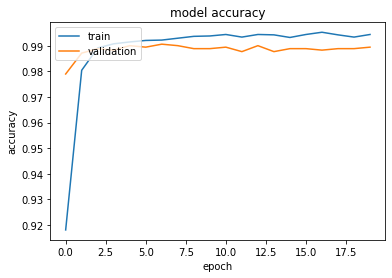

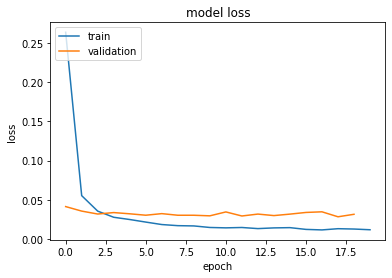

In [18]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'][1:43])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [19]:
##plot for two feature model